In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import numpy as np
import torch

from sda.mcs import *
from sda.score import *
from sda.utils import *

from utils import *

chain = make_chain()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Score network

In [2]:
score = load_score(PATH / 'runs/genial-disco-19_a6ynung2/state.pth')  # k=2, width=64

## Extrapolation

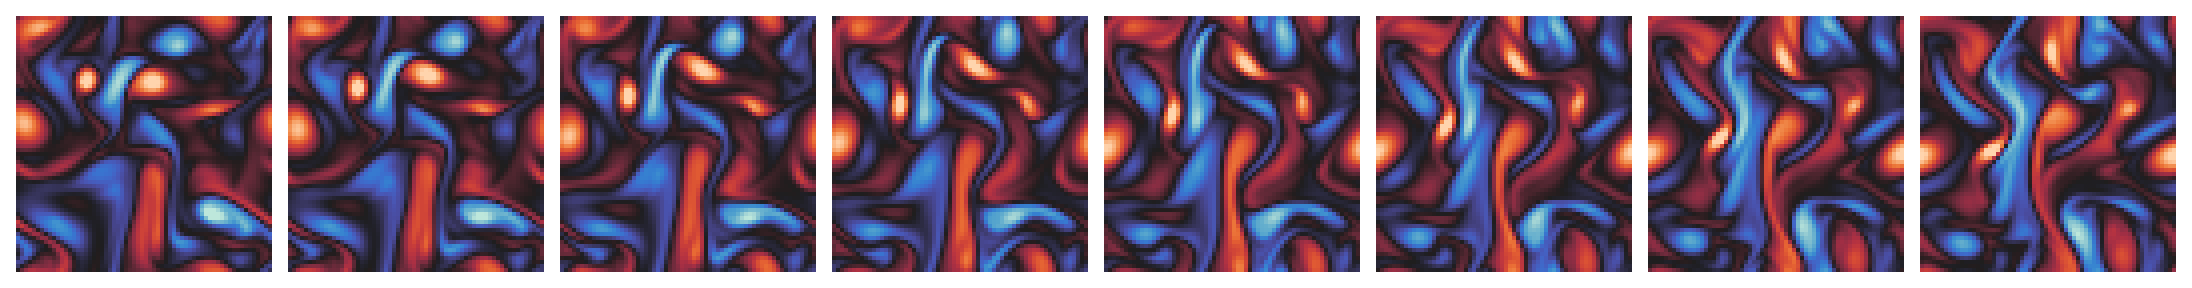

In [3]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][5, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_extra_bis.png')
draw(w, zoom=4)

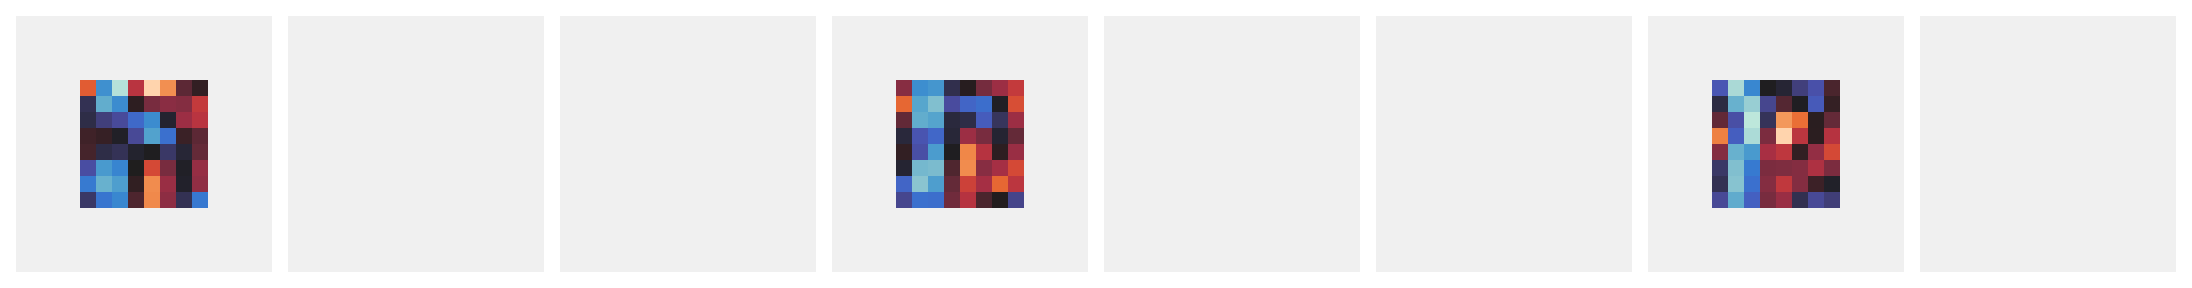

In [4]:
def A(x):
    return chain.coarsen(x, 4)[..., ::3, :, 4:12, 4:12]

y_star = torch.normal(A(x_star), 1e-2)

w = chain.vorticity(chain.coarsen(x_star, 4)) / 2

mask = np.zeros((1, 8, 16, 16), dtype=bool)
mask[:, ::3, 4:12, 4:12] = True

draw(w, mask, pad=1, zoom=16).save('y_star_extra_bis.png')
draw(w, mask, pad=1, zoom=16)

100%|█████████████████████████████████████████████████| 256/256 [01:28<00:00,  2.89it/s]


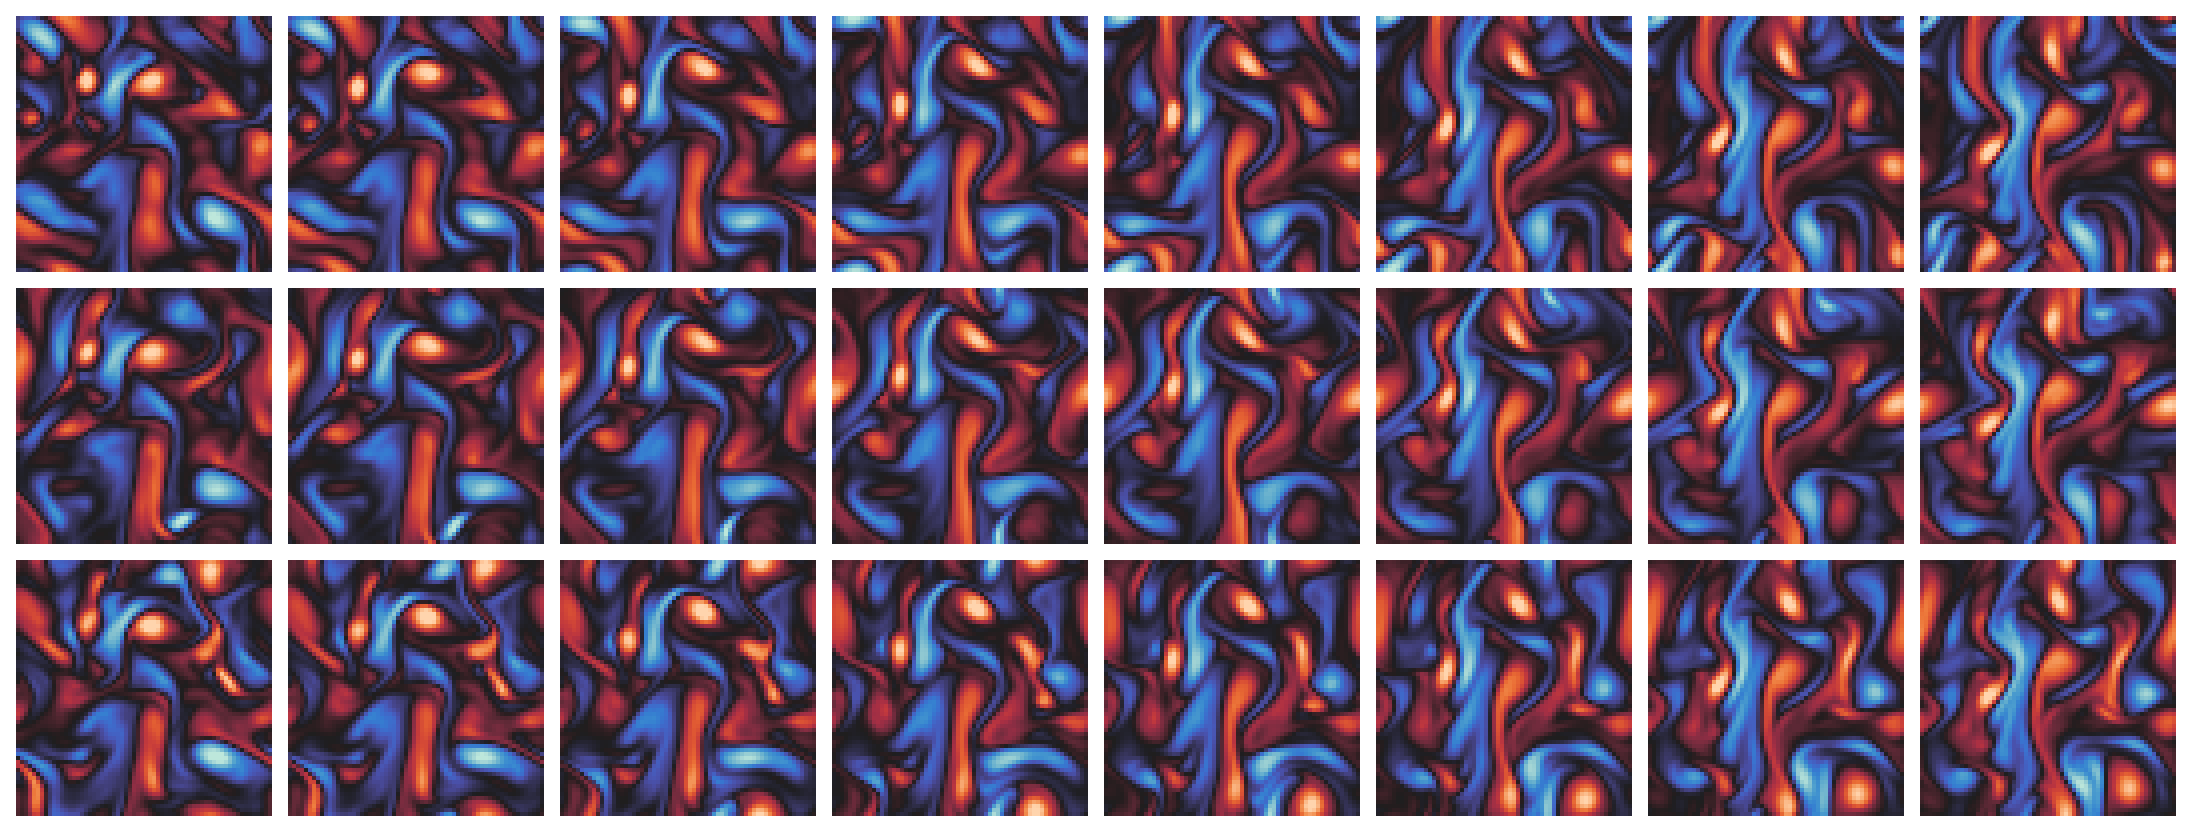

In [5]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=1e-2,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample((3,), steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save(f'x_sda_extra_bis.png')
draw(w, zoom=4)

## Subsampling

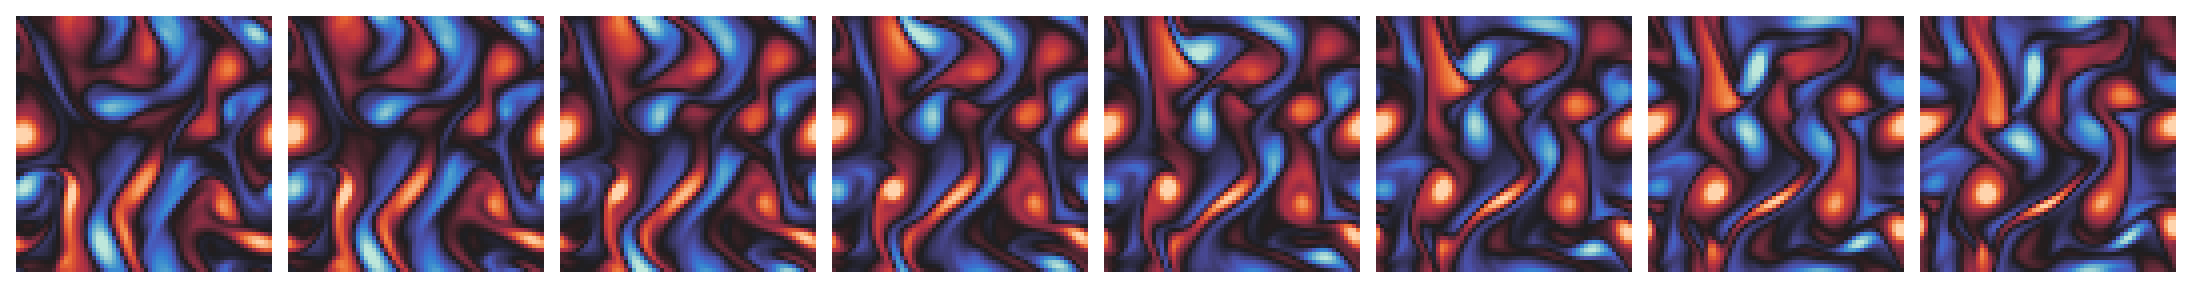

In [6]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][6, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_sub_bis.png')
draw(w, zoom=4)

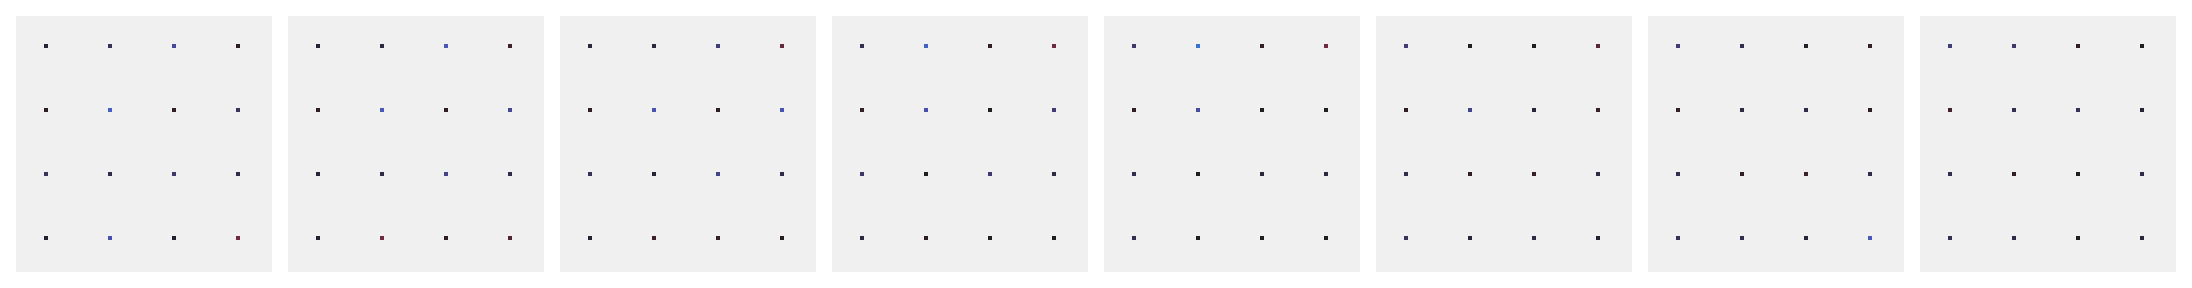

In [7]:
def A(x):
    return x[..., 7::16, 7::16]

y_star = torch.normal(A(x_star), 1e-1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[..., 7::16, 7::16] = True

draw(w, mask, zoom=4).save('y_star_sub_bis.png')
draw(w, mask, zoom=4)

100%|█████████████████████████████████████████████████| 256/256 [01:26<00:00,  2.95it/s]


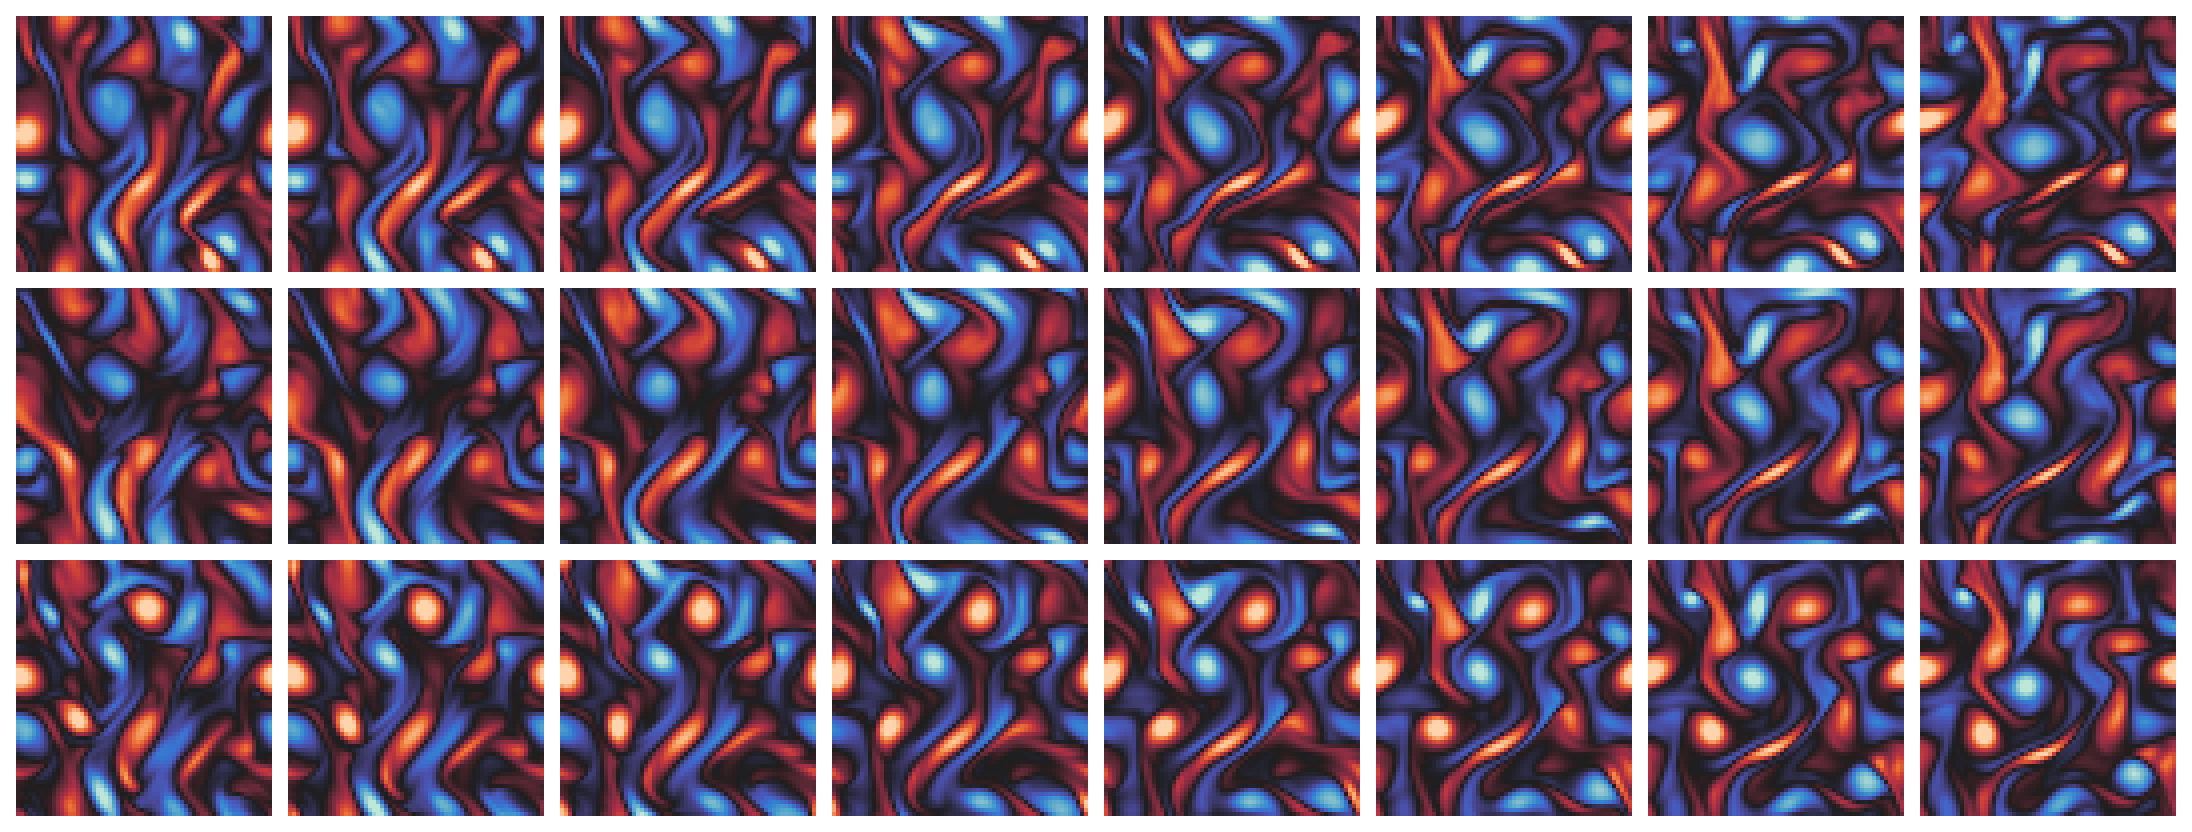

In [8]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=1e-1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample((3,), steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save(f'x_sda_sub_bis.png')
draw(w, zoom=4)